# Harmonic Oscilator Case Study

This is a short case-study of how to go from "raw" measurement (or simulation) data through exploratory visualization to an (almost) paper ready figure.

In this scenario, assume that you have fabricated (or simulated) 25 cantilevers.  There is some value (suggestively called "control") that varies between the cantilevers.  To characterize them you flex them by some fixed displacement and release the tip. You then record a time series of the displacement as the vibrations damp out.


Along the way we will touch on two libraries:
- [xarray](http://xarray.pydata.org/en/stable/index.html)
- [pandas](https://pandas.pydata.org/docs/)

to provide access to structured data.  We will also make use of `scipy` for fitting.


## Imports

In [1]:
# interactive figures, requires ipypml!
# %matplotlib widget
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

To make this notebook a bit clearer we have implemented the data access and analylis functions in a module next to this notebook.

In [2]:
from gen_data import get_data, fit

## Data Structure

As a rule-of-thumb I/O logic should be kept out of the inner loops of analysis or plotting.  This will, in the medium term, lead to more re-usable and maintainable code.  Remember your most frequent collaborator is yourself in 6 months.  Be kind to your (future) self and write re-usable, maintainable, and understandable code now ;)

In this case, we have a data (simulation) function `get_data` that will simulate the experiment and returns to us a [`xarray.DataArray`](http://xarray.pydata.org/en/stable/quick-overview.html#create-a-dataarray).   `xarray.DataArray` (roughly) a N-dimensional numpy array that is enriched with a concept of coordinates and indies on the the axes and meta-data (which we are not using here).  xarray has much more functionality than we will use in this demo (where it mostly makes the book keeping simpler)!

In [3]:
d = get_data(25)
d

<xarray.DataArray (control: 25, time: 4112)>
array([[ 1.97369701e+00,  2.01057197e+00,  2.00648372e+00, ...,
         8.25178886e-02,  1.01911614e-01,  9.92409847e-04],
       [ 1.92303835e+00,  1.92842426e+00,  2.01295694e+00, ...,
         6.94606607e-02, -1.62914385e-02, -6.77655524e-02],
       [ 2.04696992e+00,  1.97392840e+00,  1.99299277e+00, ...,
        -2.86347478e-02,  8.21037441e-02,  5.30538582e-02],
       ...,
       [ 1.91554462e+00,  1.93758333e+00,  1.95330112e+00, ...,
         4.67988277e-02, -7.18228291e-02,  1.25799592e-01],
       [ 1.94665822e+00,  2.02403749e+00,  2.02055442e+00, ...,
         1.20163941e-01,  9.29957261e-02, -3.41198974e-02],
       [ 2.00302192e+00,  1.90236979e+00,  2.00143573e+00, ...,
        -1.82160648e-02, -1.30549892e-03,  4.09985361e-02]])
Coordinates:
  * control  (control) float64 15.0 15.62 16.25 16.88 ... 28.12 28.75 29.38 30.0
  * time     (time) float64 0.0 0.007642 0.01528 0.02293 ... 31.4 31.41 31.42

Looking at the `__repr__` we see that our data in a `(25, 4112)` array.  Each row is a single measurement of the vibration as a function of time, there is a "control" index in the rows which tells us what the value of control for that cantilever was, and there is a time index on the columns.

## Just plot it!

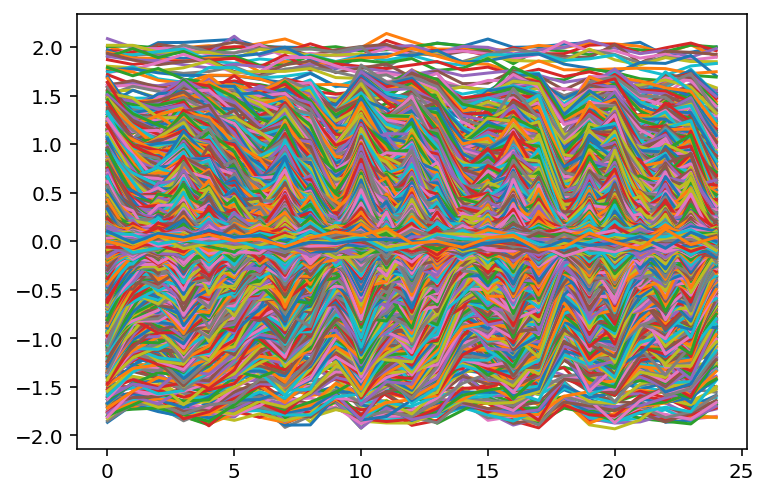

In [4]:
# plt.plot(...) would also work, but use the explicit API 
# through out to make sure this works with interactive backends.
fig, ax = plt.subplots()
ax.plot(d);

Well, OK that looks kinda-cool but not scientifically useful!  #accidentalart

If you pass a 2D array to `ax.plot` Matplotlib treats in as a column-major data set (think like a table) so this plotted ~4k lines of 25 points showing the displacement as a function of oscillator at a fixed time from release.

Lets try the transpose instead

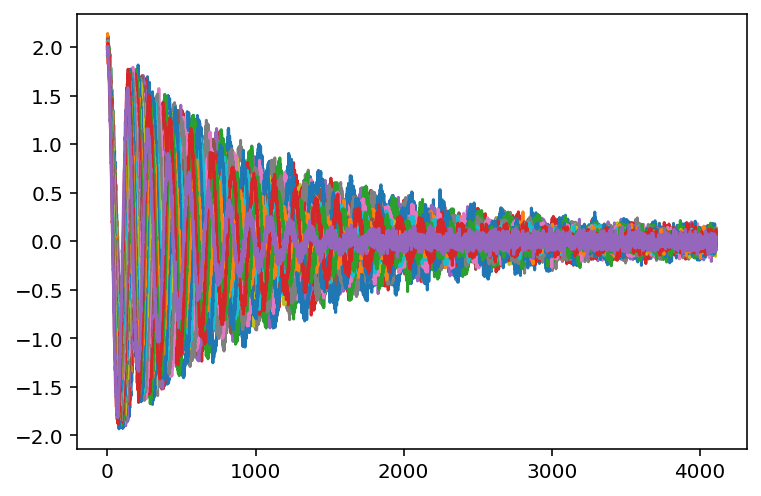

In [5]:
fig, ax = plt.subplots()
ax.plot(d.T);

That looks better!  We can see the damped oscillations and that there is some variation between the samples, however because they are all on top of each other it is impossible really make any sense of it.

While this plot is _useful_ as with the context in our heads (assuming you are reading along!), this helps us understand our data better, certainly better than looking at a print out of the float values!  However, this is a Bad Plot.  It would get marked down in a freshman physics lab: no axis labels, no title, no units, no legend, etc.  Surely we can do better.

## Look at just one

The first thing we are going to do to simplify this problem is look at just one curve, in this case the 7th row:

In [6]:
m = d[6]
m

<xarray.DataArray (time: 4112)>
array([ 2.00574156,  2.03645473,  2.02271275, ..., -0.06678653,
        0.06239504,  0.0237453 ])
Coordinates:
    control  float64 18.75
  * time     (time) float64 0.0 0.007642 0.01528 0.02293 ... 31.4 31.41 31.42

We see that as we slice into the 2D xarray we get back smaller xarrays that have carried over the coordinates from their parent in a nice way.  Control has become a scalar (as we picked out just one row) but time is still an array.

If we pass this to `plot` we get

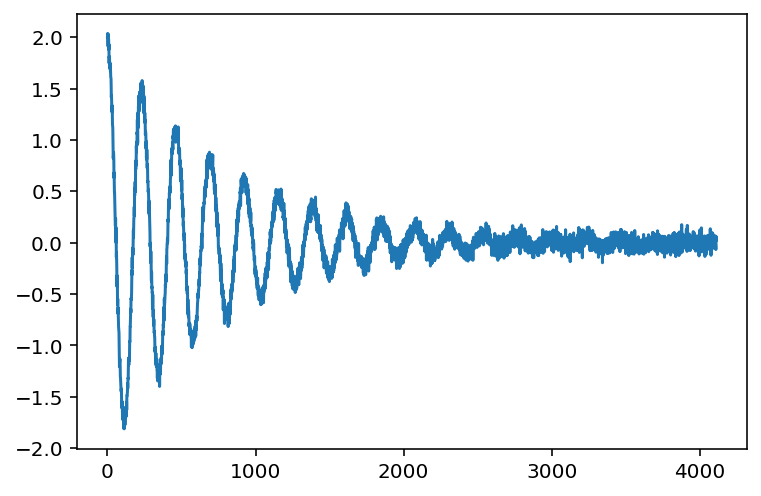

In [7]:
fig, ax = plt.subplots()
ax.plot(m)

which is much more readable than all of them all at once!  We see that this is indeed a damped oscillation and is, to eye, even.  However this is still not a good plot.  For one thing the x-axis is the positional index which is not physically meaningful in this case.

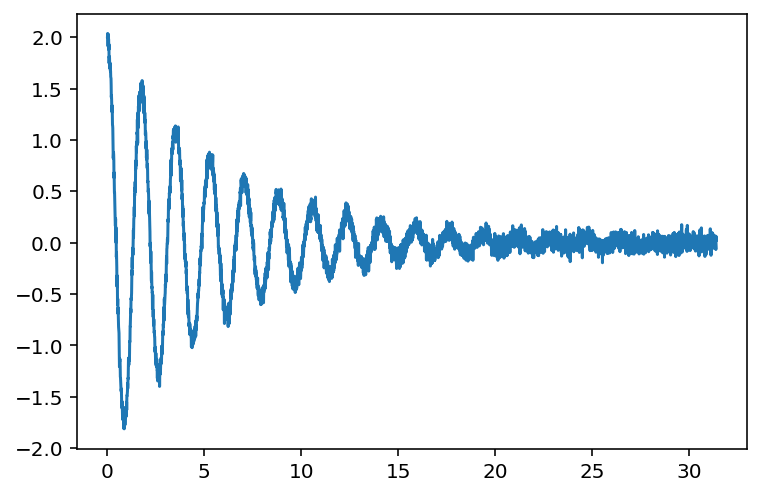

In [8]:
fig, ax = plt.subplots()
ax.plot(m.time, m)

Again, better!  We are now plotting the displacement against time rather than array index.  Note that `m.time` is a xarray niceity.  We could have just as easily had the time as another numpy array in our namespace.

As an aside, `xarray` has some built-in plotting methods that will use what it knows about the xarray data structure to give you a better plot out-of-the-box:

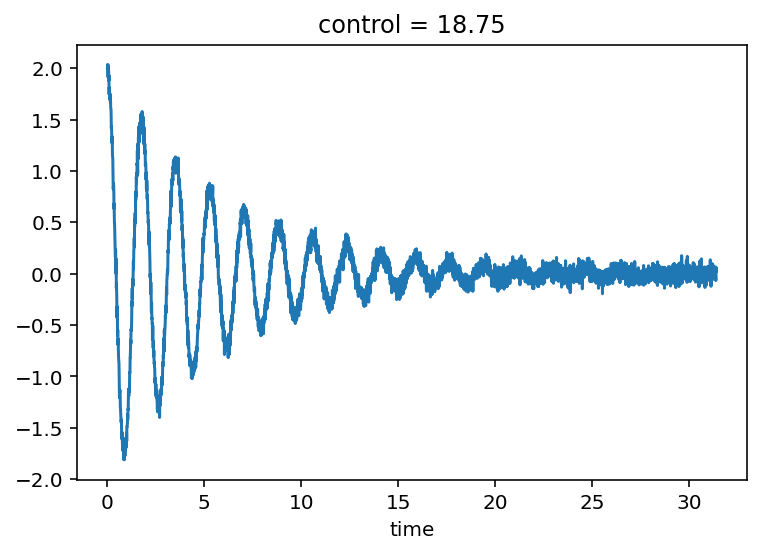

In [9]:
fig, ax = plt.subplots()
m.plot(ax=ax)

Where here it know enough to plot against `time`, label the x-axis, and sets the title with the value of control.  However, we are going to continue to work with Matplotlib as we want a bit more control.

## Add a legend, axis labels, and units

If we pass the kwarg `label` to `plot` the value will be used to populate the legend.  We can also use the `ax.set_xlabel` and `ax.set_ylabel` methods to label the axis:

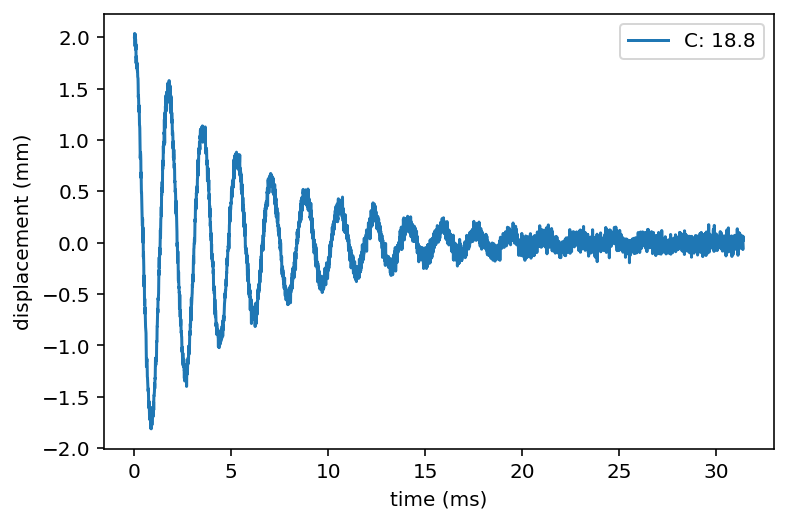

In [10]:
fig, ax = plt.subplots()

# extract values from the data
control = float(m.control)
t = m.time
z = m.values
# plot
(ln,) = ax.plot(t, z, label=f"C: {control:.1f}")

# add the legend and axis labels
ax.legend()
ax.set_xlabel("time (ms)")
ax.set_ylabel("displacement (mm)");


Good, We now have a plot that would not get marks off in a lab report!  

## Plot more than one curve at a time

However, if we wanted to add another line to this plot we would have to copy-paste-edit 4 lines of code.  This is a strong suggestion that we want to collect this code into a function we can reuse:

In [11]:
def plot_one(ax, m):
    # pull what we want out of the xarray
    control = float(m.control)
    t = m.time
    z = m.values

    (ln,) = ax.plot(t, z, label=f"C: {control:.1f}")

    return {"raw": ln}

which we can then use to plot data from 3 of the cantilevers:

Text(0, 0.5, 'displacement (mm)')

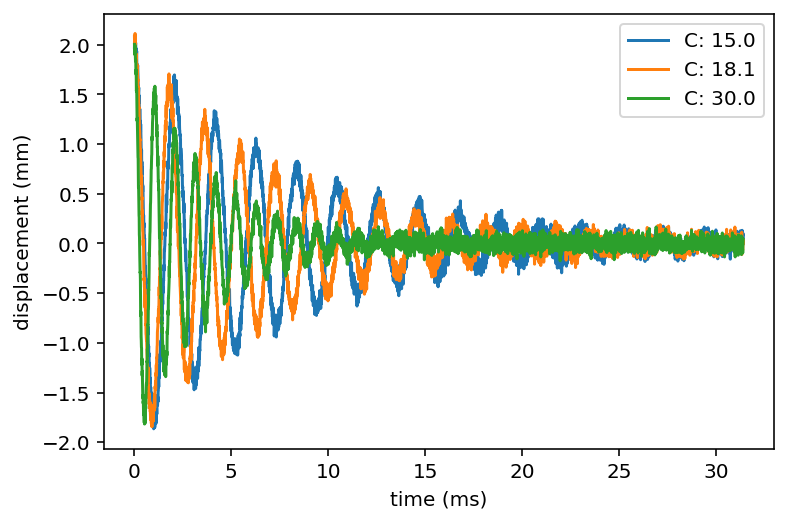

In [12]:
fig, ax = plt.subplots()
plot_one(ax, d[0])
plot_one(ax, d[5])
plot_one(ax, d[-1])
ax.legend()
ax.set_xlabel("time (ms)")
ax.set_ylabel("displacement (mm)")

This is still pretty cluttered and hard to see what is going on with the data over-lapped like this.  Because we know that the displacements are a relative measurement from the equilibrium position, we can offset the curves vertically:

Text(0, 0.5, 'displacement (mm)')

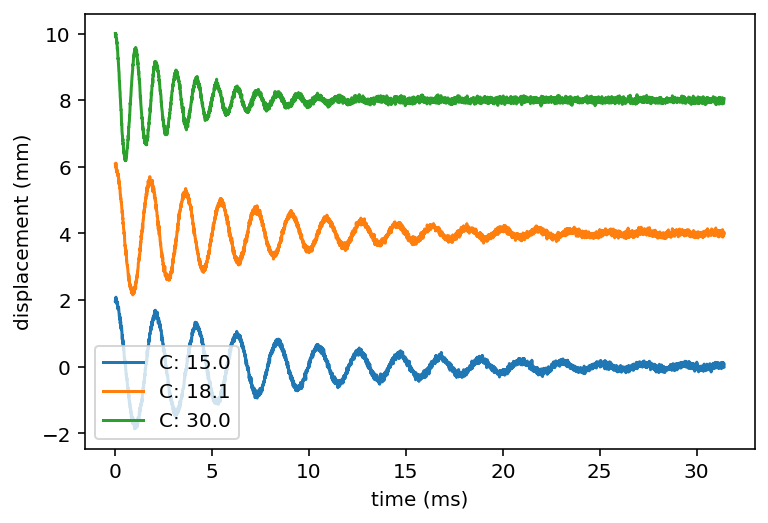

In [13]:
def plot_one(ax, m, offset=0):
    # pull what we want out of the xarray
    control = float(m.coords["control"])
    t = m.time
    z = m.values

    (ln,) = ax.plot(t, z + offset, label=f"C: {control:.1f}")

    return {"raw": ln}


fig, ax = plt.subplots()
plot_one(ax, d[0])
plot_one(ax, d[5], offset=4)
plot_one(ax, d[-1], offset=8)
ax.legend()
ax.set_xlabel("time (ms)")
ax.set_ylabel("displacement (mm)")


## Fit oscilations 

We are now going to take a brief interlude through non-linear fitting!  In `get_data` we have defined a function `fit` that fits the data to:

$$
z(t) = A e^{-\zeta\omega_0t} \sin\left(\sqrt{1 - \zeta^2}\omega_0t + \varphi\right).
$$



In [14]:
fit_vals = fit(d[6])
fit_vals

Params(A=1.9956203467239813, zeta=0.0466321168361108, omega=3.561973237567456, phi=1.571589121175182)

which gives us a nice repr in the notebook.  

### Aside about the return type of `fit`

The object returned by `fit` is a `namedtuple` of the parameters.  We get the nice view in the notebook because we implemented a `_repr_latex_` method:

In [15]:
print(fit_vals._repr_latex_())

$(A=2.00, \zeta=0.05, \omega_0=3.56,\varphi=1.57)$


We also implemented a more nicely formatted `__str__`

In [16]:
print(fit_vals)

(A=2.00, ζ=0.05, ω0=3.56, φ=1.57)


as compared to the default repr from `namedtuple`

In [17]:
print(f'{fit_vals!r}')

Params(A=1.9956203467239813, zeta=0.0466321168361108, omega=3.561973237567456, phi=1.571589121175182)


We have also implemented a `sample` method that well evaluate the fit function at the given values

In [18]:
fit_vals.sample(np.array([0, .1, .2]))

array([1.99561972, 1.83926655, 1.46091251])

### Plot the fit

Using the same methods as above we can plot the fit curve at the measured time points.

Text(0, 0.5, 'displacement (mm)')

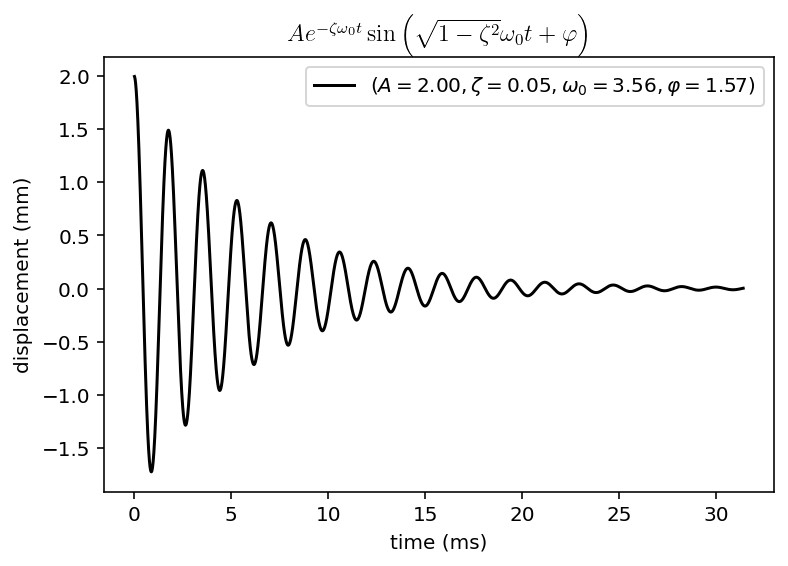

In [19]:
fig, ax = plt.subplots()
ax.plot(m.time, fit_vals.sample(m.time), label=fit_vals._repr_latex_(), color='k')
plt.gca().set_title(
     r"$A e^{-\zeta\omega_0t} \sin\left(\sqrt{1 - \zeta^2}\omega_0t + \varphi\right)$",
     usetex=True,
)

plt.legend()
ax.set_xlabel("time (ms)")
ax.set_ylabel("displacement (mm)")


Note that the Greek letters in the title and the legend look slightly different.  This is because Matplotlib has two ways of handling math expressions:

1. a builtin, but restricted, $\LaTeX$ parser and renderer
2. calling out to system $\LaTeX$

In this case the legend is using the built in one and the title is using the system $\LaTeX$.

## Add the fit to our plotting function

Now that we can fit the data, lets add that to our `plot_one` function so that we can overlay the fit on the raw data.

In [20]:
def plot_one(ax, m, fit_vals, offset=0):
    # pull what we want out of the xarray
    control = float(m.coords["control"])
    t = m.coords["time"]
    z = m.values

    (ln,) = ax.plot(t, z + offset, label=f"C: {control:.1f}")
    (fit,) = ax.plot(t, fit_vals.sample(t) + offset, color="k")
    ann = ax.annotate(
        f"$\\zeta={fit_vals.zeta:.2g}$, $\\omega_0={fit_vals.omega:.2f}$",
        # units are (axes-fraction, data)
        xy=(0.95, offset + 0.5),
        xycoords=ax.get_yaxis_transform(),
        # set the text alignment
        ha="right",
        va="bottom",
    )
    return {"raw": ln, "fit": fit, "annotation": ann}



Text(0, 0.5, 'displacement (mm)')

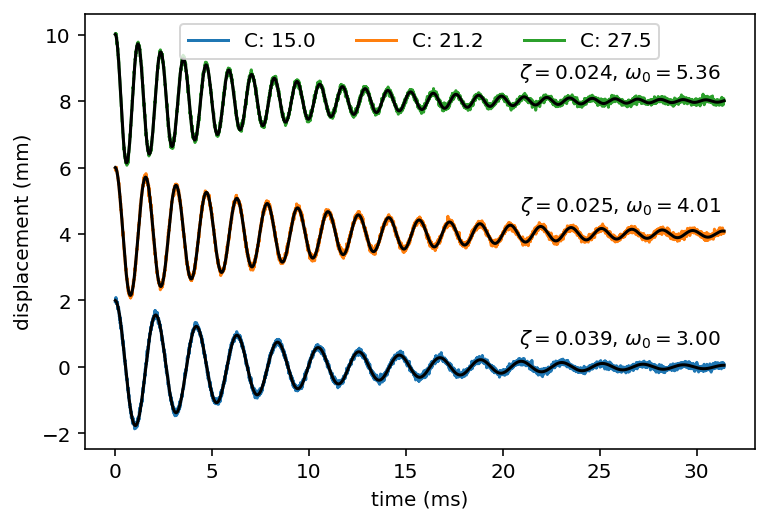

In [21]:
fig, ax = plt.subplots()
plot_one(ax, d[0], fit(d[0]))
plot_one(ax, d[10], fit(d[10]), offset=4)
plot_one(ax, d[20], fit(d[20]), offset=8)
ax.legend(ncol=3, loc="upper center")
ax.set_xlabel("time (ms)")
ax.set_ylabel("displacement (mm)")


This plot is starting to get a little busy and the color of the lines is a bit hard to track with the fit over plotted.   Given that we are already using `ax.annotate` to label the fit parameters, lets move `'C'` to the annotation as well.


In [22]:
def plot_one(ax, m, fit_vals, offset=0):
    # pull what we want out of the xarray
    control = float(m.coords["control"])
    t = m.coords["time"]
    z = m.values

    (ln,) = ax.plot(t, z + offset, label=f"C: {control:.1f}")
    (fit,) = ax.plot(t, fit_vals.sample(t) + offset, color="k")
    ann = ax.annotate(
        (
            f"$C={control:.1f}$\n"
            f"$\\zeta={fit_vals.zeta:.2g}$, $\\omega_0={fit_vals.omega:.2f}$"
        ),
        # units are (axes-fraction, data)
        xy=(0.95, offset + 0.5),
        xycoords=ax.get_yaxis_transform(),
        # set the text alignment
        ha="right",
        va="bottom",
    )
    return {"raw": ln, "fit": fit, "annotation": ann}


Text(0, 0.5, 'displacement (mm)')

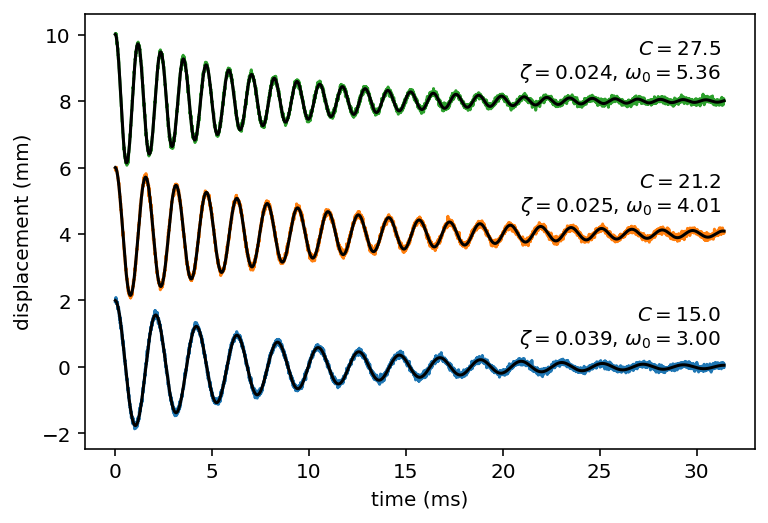

In [23]:
fig, ax = plt.subplots()
plot_one(ax, d[0], fit(d[0]))
plot_one(ax, d[10], fit(d[10]), offset=4)
plot_one(ax, d[20], fit(d[20]), offset=8)
ax.set_xlabel("time (ms)")
ax.set_ylabel("displacement (mm)")


We are now back at to a situation very much like when we pulled the plotting code up into `plot_one` above.  Each time we want to add another line we have to change 3 things in a coordinated way: the raw data index in 2 places and the offset.  This is a code-smell that we should write another function!

In [24]:
def plot_several(ax, d, fits):
    out = []

    for j, (m, popt) in enumerate(zip(d, fits)):
        arts = plot_one(ax, m, popt, offset=4 * j)
        out.append(arts)

    ax.set_xlabel("time (ms)")
    ax.set_ylabel("displacement (mm)")

    return out


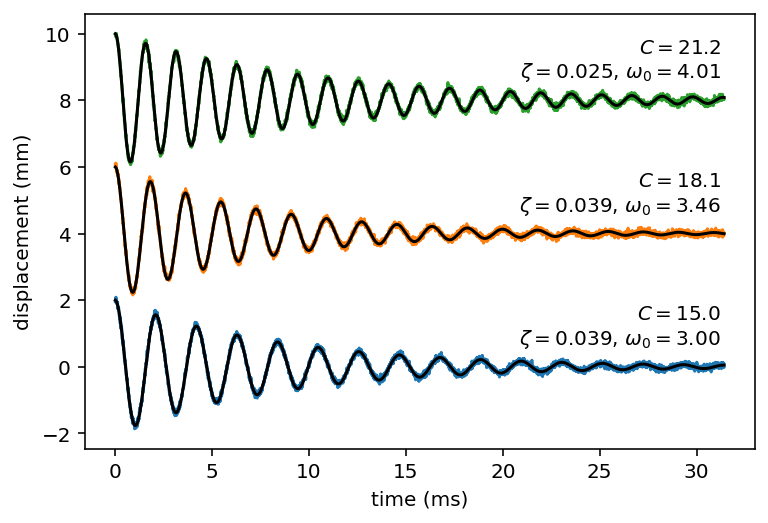

In [25]:
fig, ax = plt.subplots()
indx = [0, 5, 10]
plot_several(ax, d[indx], [fit(d[i]) for i in indx]);


## Look at the fit values

Now that we have a good handle on plotting the raw data, lets turn to looking at how the fit parameters change with "control" (as this is probably the thing we care about from a science point of view!).

Above we had been fitting the data on an as-needed basis so lets go ahead and fit all of our raw data

In [26]:
fits = [fit(m) for m in d]                               # fit all of the curves
fits

[Params(A=1.9985108278742656, zeta=0.03932455383040072, omega=3.0005704480163025, phi=1.567668418156002),
 Params(A=1.9966583417683628, zeta=0.059832680177358044, omega=3.0846385230254767, phi=1.5719927504499325),
 Params(A=2.0086815554858606, zeta=0.054054251457832325, omega=3.1746291259396906, phi=1.5720867986418596),
 Params(A=1.9996764904048534, zeta=0.034500239804923116, omega=3.2654198104336194, phi=1.572239367989118),
 Params(A=2.007510723447249, zeta=0.03499158704144695, omega=3.3607126153121527, phi=1.5736002431133471),
 Params(A=1.9973155908242706, zeta=0.03948329646032252, omega=3.4597456027038245, phi=1.5724862094391325),
 Params(A=1.9956203467239813, zeta=0.0466321168361108, omega=3.561973237567456, phi=1.571589121175182),
 Params(A=1.9987104229506465, zeta=0.0304382667890974, omega=3.668610501050451, phi=1.569211057535144),
 Params(A=2.001882883876059, zeta=0.037342644145337923, omega=3.777646397971457, phi=1.5694551213069974),
 Params(A=2.0055655025398504, zeta=0.0593034

That looks a lot like a table, so let put these results into a `pandas.DataFrame`

In [27]:
fits_df = pd.DataFrame(fits, index=d.coords["control"])  # put the fit values is a DataFrame
fits_df

,A,zeta,omega,phi
control,,,,
15.000,1.998511,0.039325,3.000570,1.567668
15.625,1.996658,0.059833,3.084639,1.571993
16.250,2.008682,0.054054,3.174629,1.572087
16.875,1.999676,0.034500,3.265420,1.572239
17.500,2.007511,0.034992,3.360713,1.573600
18.125,1.997316,0.039483,3.459746,1.572486
18.750,1.995620,0.046632,3.561973,1.571589
19.375,1.998710,0.030438,3.668611,1.569211
20.000,2.001883,0.037343,3.777646,1.569455


Pandas can do a whole lot more than we are going to use in this case-study, but for this we are just going to make use of the columnar data access and the index.

Similar to `xarray` (technically `xarray` is similar to `pandas` as `pandas` existed first), `pandas` has a plotting method on the data structure.

<AxesSubplot:xlabel='control'>

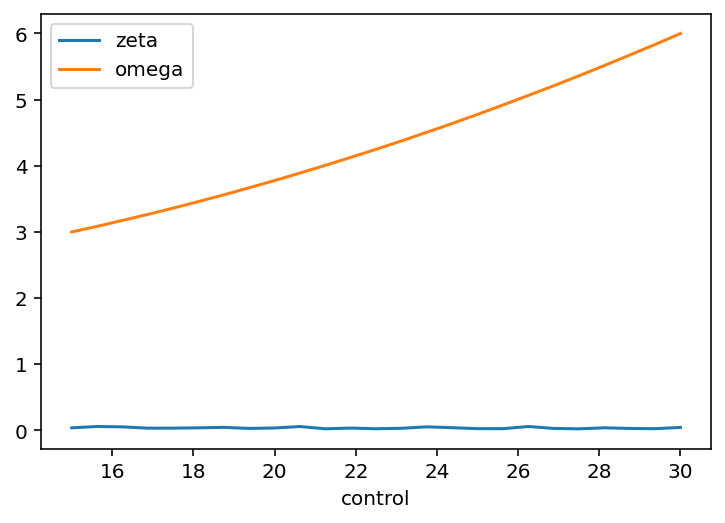

In [28]:
fig, ax = plt.subplots()
fits_df.plot(y=['zeta', 'omega'], ax=ax)

On one hand, this is a very _useful_ plot.  Pandas as used the index (the *control* values) as the x-axis (good!), labeled the lines based on the columns names (good!), and we can eye-ball the functional forms of the dependency of $\zeta$ and $\omega_0$ on *control*.  However, this is also a Bad Plot: the two columns are different by an order of magnitude and have different units!

We can follow the pattern we used above with `plot_one` / `plot_several` and write two helper functions to plot the $\zeta$ and $\omega_0$ results:

In [29]:
def plot_zeta(ax, fits_df):
    ax.set_ylabel(r"$\zeta$")
    ax.set_xlabel("control (arb)")
    ax.set_ylim(0, 0.1)
    return ax.plot(
        fits_df["zeta"],
        marker="o",
        color="k",
        label="\N{greek small letter zeta}",
        linestyle="",
    )


def plot_omega(ax, fits_df):
    ax.set_ylabel(r"$\omega_0/2\pi$ (kHz)")
    ax.set_xlabel("control (arb)")
    ax.set_ylim(0, 1.5)
    return ax.plot(
        fits_df["omega"] / (2 * np.pi),
        marker="o",
        color="k",
        label="\N{greek small letter omega}0",
    )



Which we can make an 2 Axes figure at take a look at

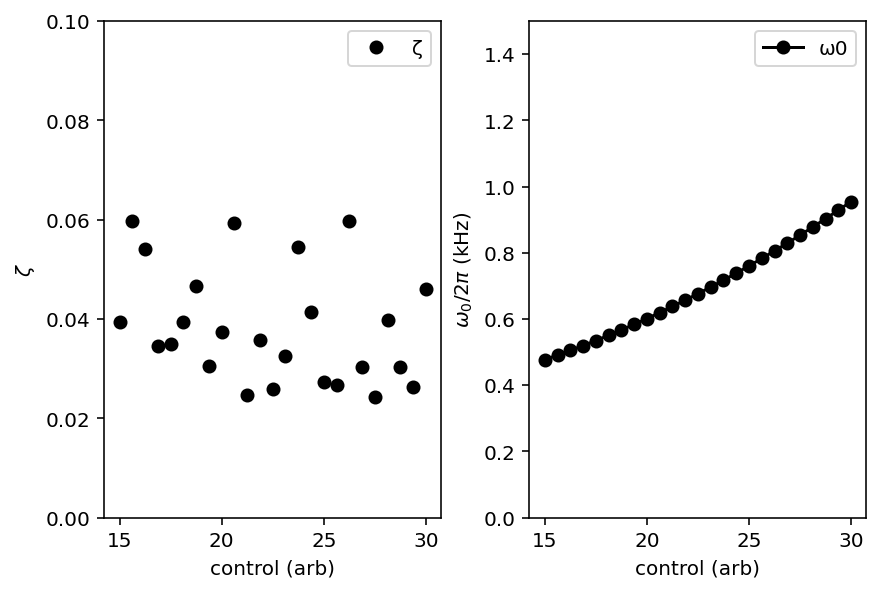

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True)
plot_zeta(ax1, fits_df)
plot_omega(ax2, fits_df)
ax1.legend()
ax2.legend()

## Put it all together

Now that we have helper functions to plot our raw data and the fit values, lets put them all together in one figure.

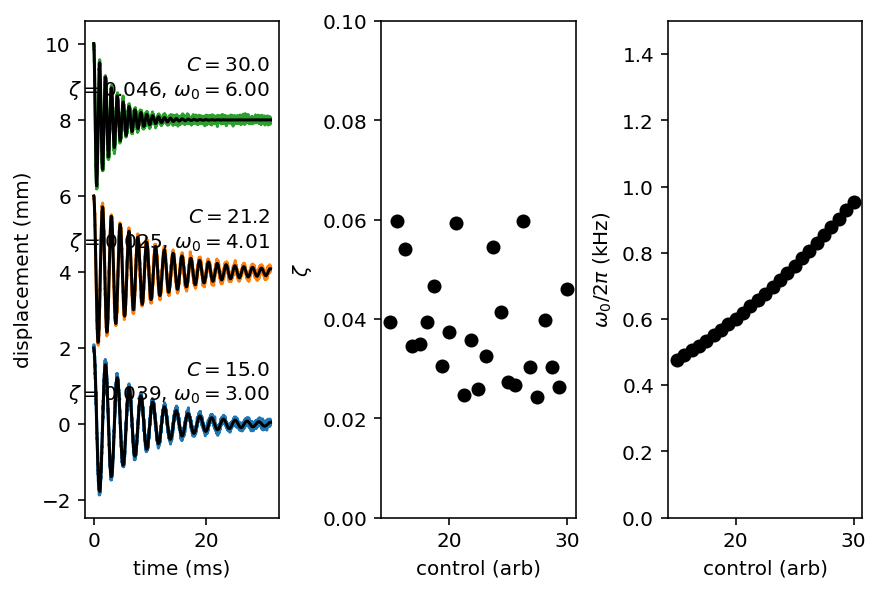

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, constrained_layout=True)
indx = [0, 10, 24]
plot_several(ax1, d[indx], [fits[i] for i in indx])
plot_zeta(ax2, fits_df)
plot_omega(ax3, fits_df)



On the plus side, we have all of the data we want to show in one figure and each `Axes` is labeled correctly, however is not using the screen real estate the most efficient way.  Making use of a feature adding in [Matplotlib 3.3](https://matplotlib.org/stable/users/whats_new.html#provisional-api-for-composing-semantic-axes-layouts-from-text-or-nested-lists) we easily specify complex layouts.

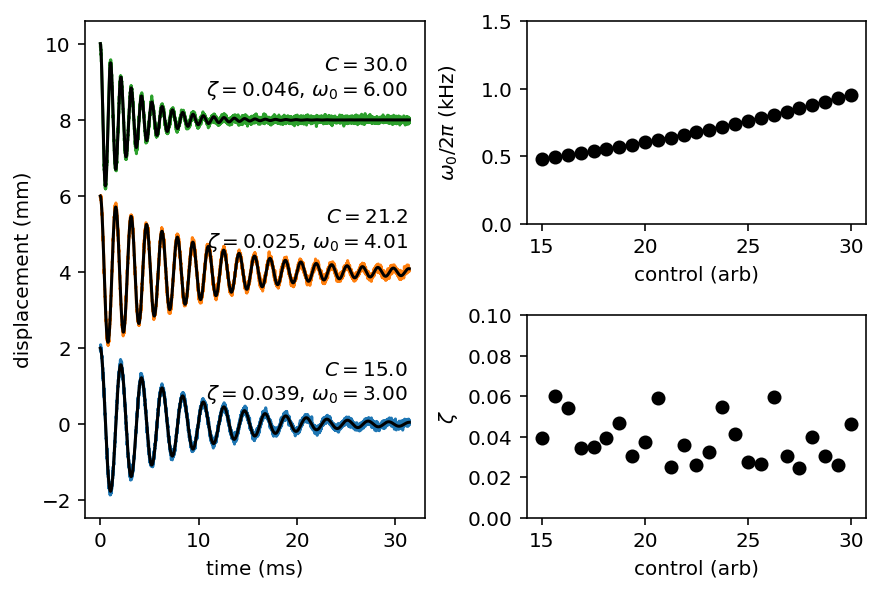

In [32]:
fig, ax_dict = plt.subplot_mosaic(
    [["raw", "omega"], 
     ["raw", "zeta"]], constrained_layout=True
)
indx = [0, 10, 24]
plot_several(ax_dict["raw"], d[indx], [fits[i] for i in indx])
plot_zeta(ax_dict["zeta"], fits_df)
plot_omega(ax_dict["omega"], fits_df)
fig.align_ylabels(list(ax_dict.values()))


Something that we are missing if we want to use this as a paper figure is sub-plot labels so we can refer to them directly in the caption and text.  We are going to reuse `Axes.annotate` as we did for the labels in th displacement plots. 

In [33]:
def subplot_label(ax, text):
    return ax.annotate(
        text,
        # units are (axes-fraction, axes-fraction)
        # # this is bottom right
        # xy=(1, 0),
        # this is the top left
        xy=(0, 1),
        xycoords="axes fraction",
        # units are absolute offset in points from xy
        xytext=(-5, 5),
        textcoords=("offset points"),
        # set the text alignment
        ha="right",
        va="bottom",
        fontweight="bold",
        fontsize="larger",
    )


While this is _technically_ only one line of code, we wrap this up in a function to make it easier to refer to!

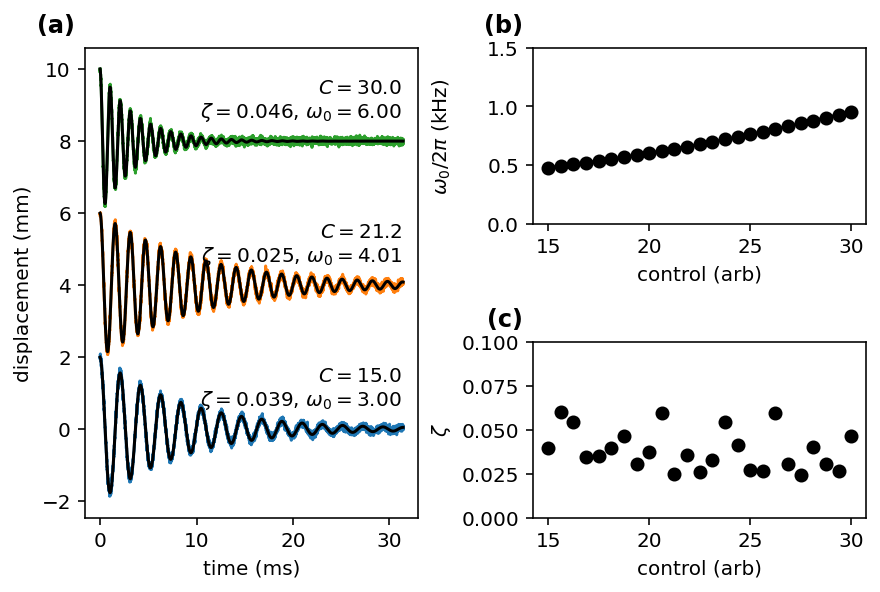

In [34]:
fig, ax_dict = plt.subplot_mosaic(
    [["raw", "omega"], ["raw", "zeta"]], constrained_layout=True
)
indx = [0, 10, 24]
plot_several(ax_dict["raw"], d[indx], [fits[i] for i in indx])
plot_zeta(ax_dict["zeta"], fits_df)
plot_omega(ax_dict["omega"], fits_df)
fig.align_ylabels(list(ax_dict.values()))
for k, v in {"raw": "a", "omega": "b", "zeta": "c"}.items():
    subplot_label(ax_dict[k], f"({v})")


Following the same pattern as we saw above, we now have a handful of lines of code that if we want to re-use we will have to copy-paste together so we wrap them up in a function (suggestively called `paper_figure_2`:

In [35]:
def paper_figure_2(fig, layout, d, fits, *, plot_every=5):
    ax_dict = fig.subplot_mosaic(layout)

    fits_df = pd.DataFrame(fits, index=d.coords["control"])

    index = list(range(0, len(d), plot_every))

    artists = {
        "vibrations": plot_several(ax_dict["raw"], d[index], [fits[i] for i in index]),
        "zeta": plot_zeta(ax_dict["zeta"], fits_df),
        "omega": plot_omega(ax_dict["omega"], fits_df),
    }

    fig.align_ylabels(list(ax_dict.values()))

    subplot_labels = {
        k: subplot_label(ax_dict[k], f"({v})")
        for k, v in {"raw": "a", "omega": "b", "zeta": "c"}.items()
    }

    return (fig, ax_dict, artists, subplot_labels)



A final thing we want to tune is that for a journal paper you do not get to make the plots an arbitrary size, they have to match the column or page size of the journal.  For APS journals you have the choice of a 2-column figure that spans the page or a single column figure.

In [36]:
single_col_width = 8.6 / 2.54  # single column APS figure
double_col_width = 17.8 / 2.54  # double column APS figure


We can now look at what our figure would look like rendered at the correct size for a 2 column figure:

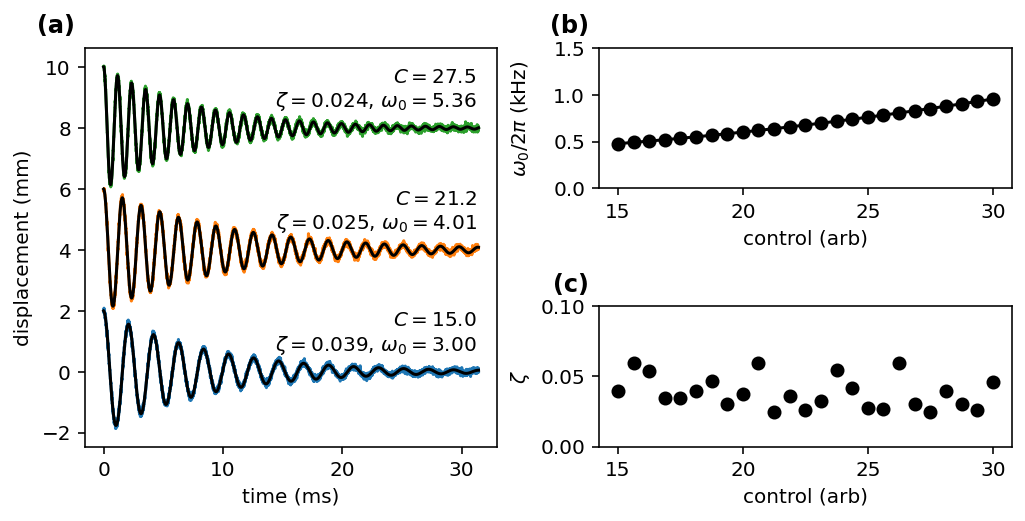

In [37]:
fig, axs, arts, labels = paper_figure_2(
    plt.figure(
        constrained_layout=True, figsize=(double_col_width, double_col_width * 0.5)
    ),
    [["raw", "omega"], ["raw", "zeta"]],
    d,
    fits,
    plot_every=10,
)


or maybe we want to look at this as a 1 column (but tall) figure:

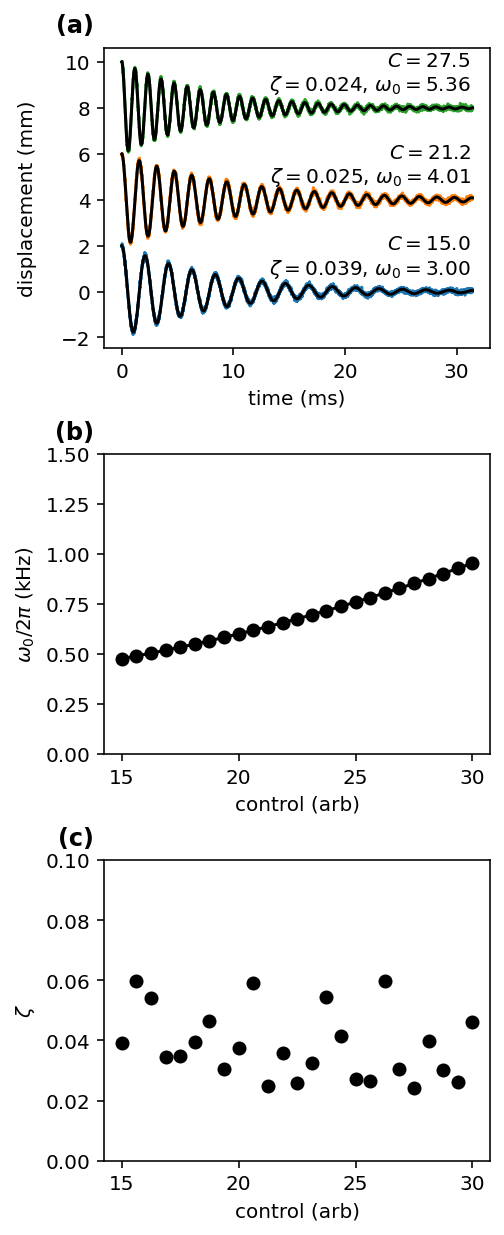

In [38]:
fig, axs, arts, labels = paper_figure_2(
    plt.figure(
        constrained_layout=True, figsize=(single_col_width, single_col_width * 2.5)
    ),
    [["raw"], ["omega"], ["zeta"]],
    d,
    fits,
    plot_every=10,
)


## Conclusion

I hope you enjoyed this very rapid path from get-it-on-the-screen exploratory data analysis to a (almost) journal ready figure!  Over the course of this notebook (or the `step_*.py` files adjacent to it) we have slowly built up a mini-library of helper functions tuned to exactly this data set for this experiment.  As shown at the end, by putting in the bit of extra effort to wrap parts of the visualization in functions we could easily adjust the layout of the figure.  In this case we switch from a 2 column to 1 column layout, but paper figures frequently need to be adapted to talk figures, or poster figures, on just sub-panel a) needs to be pulled out for a grant report, or ....

### TL;DR

1. Matplotlib can be used for both exploratory visualization and publications.
2. Matplotlib can be fully controlled from Python.
3. Make use of Python as a language to build yourself useful tools along the way.